In [68]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm
device= "cpu"


def alpha(i, R, tau):
    return 1-torch.exp(-(R/tau)*i)

def action(state, R, tau):
    deltaSIR= torch.zeros_like(state)
    deltaSIR[0]= -state[0]*alpha(state[1], R, tau)
    deltaSIR[2]= state[1]/tau
    deltaSIR[1]= -deltaSIR[0]-deltaSIR[2]
    return state+deltaSIR, -deltaSIR[0]

timeHorizon= 20
R0= 8.37
tau0= 6.2
deltaSs= [torch.tensor(0.01, dtype=torch.float32, device=device)]
noise= torch.randn((timeHorizon+1), dtype= torch.float32, device=device)/400
stateNow= torch.tensor([0.99, 0.01, 0], dtype= torch.float32, device= device)
for i in range(timeHorizon):
    stateNow, deltaS= action(stateNow, R0, tau0)
    deltaSs.append(deltaS.clone())
deltaSs= torch.stack(deltaSs)+noise
deltaSs= torch.cat((deltaSs, deltaSs, deltaSs, deltaSs, deltaSs, deltaSs, deltaSs))
indices = torch.arange(deltaSs.shape[0]).unsqueeze(0)/deltaSs.shape[0]
embedded_tensor = torch.cat((indices, deltaSs.unsqueeze(0)), dim=0)
embedded_tensor= embedded_tensor.T
print(embedded_tensor.shape)

tensor([[ 1.0000e+00,  5.1947e-03,  1.1462e-02, -1.2067e-02,  1.7663e-03],
        [ 1.1183e-02,  1.0000e+00,  9.6817e-03,  7.0455e-03, -1.1961e-03],
        [-5.3482e-03, -1.2599e-02,  1.0000e+00, -5.2365e-03,  1.7189e-03],
        [ 1.8089e-02,  9.3217e-03,  4.6061e-03,  1.0000e+00,  1.8704e-03],
        [-1.8933e-04,  1.6074e-02, -1.8950e-03,  8.4653e-03,  1.0000e+00]])
torch.Size([147, 2])


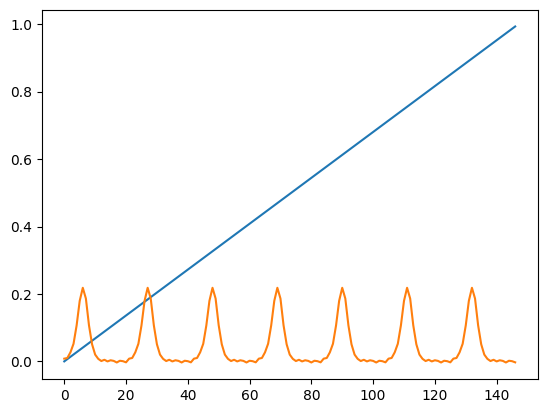

In [67]:
plt.plot(embedded_tensor.cpu().detach())

In [3]:

class MultiHeadAttention(torch.nn.Module):
    def __init__(self, input_dim= (21, 2), num_heads= 2, atten_dim= 1):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.input_dim= input_dim
        self.atten_dim= atten_dim
        # Linear transformations for queries, keys, and values
        self.W_q = torch.nn.Linear(input_dim[1], num_heads* input_dim[1])
        self.W_k = torch.nn.Linear(input_dim[1], num_heads* input_dim[0]*input_dim[1])
        self.W_v = torch.nn.Linear(input_dim[0], num_heads* input_dim[0])
        self.myAct= torch.nn.Softmax(dim= 1)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # Calculate scaled dot product attention
        attention_scores = torch.matmul(Q, K)

        if mask is not None:
            attention_scores = attention_scores.masked_fill(mask == 0, float('-inf'))

        attention_weights = F.softmax(attention_scores, dim=-1)
        output = torch.matmul(attention_weights, V)
        return output.squeeze(dim=-1)

    def forward(self, x, mask=None):
        # Linear transformations
        Q = self.W_q(embedded_tensor).view(x.shape[0], self.num_heads, 1, x.shape[1])
        K = self.W_k(embedded_tensor).view(x.shape[0], self.num_heads, x.shape[1], x.shape[0])
        V = self.W_v(embedded_tensor.T[self.atten_dim]).view(1, self.num_heads, x.shape[0], 1)
        # Apply attention
        attention_output = self.scaled_dot_product_attention(Q, K, V, mask)
        return self.myAct(attention_output)

In [4]:
class Epis(torch.nn.Module):
    def __init__(self, input_dim= 20, num_heads= 1, device= "cpu"):
        super(Epis, self).__init__()
        self.device= device
        self.tau= torch.tensor(4, dtype= torch.float32, device=device)
        self.tau= torch.nn.Parameter(self.tau)
        self.R0dTaus= torch.tensor(5, dtype= torch.float32, device=device)
        self.R0dTaus= torch.nn.Parameter(self.R0dTaus)
        self.mat, self.mask= self.create_temporal_mat(input_dim)
        self.myRelu= torch.nn.ReLU()

    def alpha(self, i, R0, tau):
        return 1-torch.exp(-(R0/tau)*i)
    
    def create_temporal_mat(self, lang):
        mat= torch.zeros((lang, lang), dtype= torch.float32, device= self.device)
        mask= torch.zeros((lang, lang), dtype= torch.float32, device= device)
        for i in range(lang):
            for j in range(i+1):
                mat[i, j]= i- j +1
                mask[i, j]= 1
        return mat, mask

    def forward(self, x): # shape: (20, 2, 1)
        noise= x[:, 0, :] #\noise delta S
        signal= self.myRelu(x[:, 1, :]) #\delta S
        Ss= 1- torch.cumsum(signal, dim=0)
        IsMat= torch.exp(self.mat*torch.log(1-1/self.tau))*self.mask# V
        Is= torch.matmul(IsMat, signal)# V
        predSignal= (1-torch.exp(-self.R0dTaus*Is))*Ss
        #signalPredict= self.alpha(Is[0: -1], R0, tau)*Ss[0:-1] 
        return predSignal, signal, noise

In [5]:
class Epis(torch.nn.Module):
    def __init__(self, input_dim= 20, num_heads= 1, device= "cpu"):
        super(Epis, self).__init__()
        self.device= device
        self.num_heads= num_heads
        self.taus= torch.ones(num_heads, dtype= torch.float32, device=device)*5
        self.taus= torch.nn.Parameter(self.taus)
        self.R0dTaus= torch.ones(num_heads, dtype= torch.float32, device=device)*6
        self.R0dTaus= torch.nn.Parameter(self.R0dTaus)
        self.mat, self.mask= self.create_temporal_mat(input_dim)
        self.myRelu= torch.nn.ReLU()

    def alpha(self, i, R0, tau):
        return 1-torch.exp(-(R0/tau)*i)
    
    def create_temporal_mat(self, lang):
        mat= torch.zeros((lang, lang), dtype= torch.float32, device= self.device)
        mask= torch.zeros((lang, lang), dtype= torch.float32, device= device)
        for i in range(lang):
            for j in range(i+1):
                mat[i, j]= i- j +1
                mask[i, j]= 1
        return mat[None, None, ...], mask[None, None, ...]

    def forward(self, x): # shape: (1, 2, 20), dim of nodes, dim of heads, dim of signal
        noise= x[:, 0, :] #\noise delta S
        signal= self.myRelu(x[:, 1:, :]) #\delta S
        Ss= 1- torch.cumsum(signal, dim= -1) #easiy negative
        IsMat= torch.exp(self.mat*torch.log(1-1/self.taus[None, :, None, None]))*self.mask# V
        Is= torch.matmul(IsMat, signal[..., None]).squeeze(dim=-1)# V
        predSignal= (1-torch.exp(-self.R0dTaus[None, :, None]*Is))*Ss
        #signalPredict= self.alpha(Is[0: -1], R0, tau)*Ss[0:-1] 
        return predSignal, signal, noise

In [61]:
att= MultiHeadAttention(input_dim= embedded_tensor.shape, num_heads= 8, atten_dim= 1)
myEpi=Epis(input_dim= embedded_tensor.shape[0], num_heads= 7)
optimizer = torch.optim.Adam(att.parameters(), lr=1e-2)
optimizer2 = torch.optim.Adam({myEpi.taus, myEpi.R0dTaus},lr=1e-3)
myloss= torch.nn.MSELoss(reduction='sum')
losses= []

In [62]:
for j in tqdm(range(20000)):
    optimizer.zero_grad()
    optimizer2.zero_grad()
    output= att(embedded_tensor)
    divide= output.squeeze()*embedded_tensor[:, 1:]
    divide= divide.T
    predSignal, signal, noise= myEpi(divide[None, ...])
    loss= myloss(predSignal[:, :, 0:-1], signal[:, :, 1:])+ torch.abs(noise.sum())
    losses.append(loss.item())
    loss.backward(retain_graph=True)
    optimizer.step()
    optimizer2.step()
print(loss)
#print(divide.T)
#print(tau)
#print(R0)

100%|██████████| 20000/20000 [04:52<00:00, 68.35it/s]

tensor(0.0009, grad_fn=<AddBackward0>)


In [63]:
print(myEpi.taus)
print(myEpi.R0dTaus)
#R0= 8.37
#tau0= 7.5

Parameter containing:
tensor([3.9109, 3.0517, 1.9161, 2.3866, 2.5623, 2.3935, 2.8796],
       requires_grad=True)
Parameter containing:
tensor([1.9802, 2.3420, 3.8133, 2.9115, 2.7263, 2.8966, 2.4432],
       requires_grad=True)


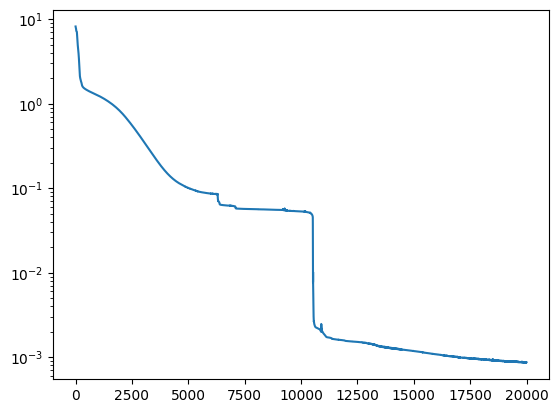

In [64]:
plt.plot(losses)
plt.yscale("log")

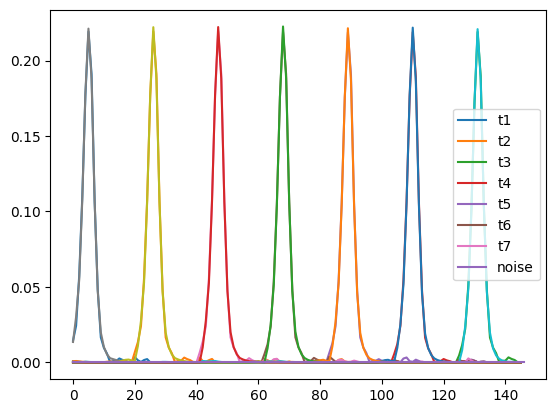

In [65]:
plt.plot(signal[:, :, 1:].squeeze().T.cpu().detach(), label=["t1", "t2", "t3", "t4", "t5", "t6", "t7"])
plt.plot(predSignal[:, :, 0:-1].squeeze().T.cpu().detach())
plt.plot(noise.T.cpu().detach(), label= "noise")
plt.legend()

In [54]:
print(predSignal)

tensor([[[ 2.8981e-04,  6.5643e-04,  1.1764e-03,  ..., -4.8123e-06,
          -2.5756e-06, -1.3793e-06],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 1.7367e-04,  3.9734e-04,  7.1843e-04,  ..., -0.0000e+00,
          -0.0000e+00, -0.0000e+00],
         ...,
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 1.2435e-02,  2.8584e-02,  5.2121e-02,  ..., -0.0000e+00,
          -0.0000e+00, -0.0000e+00],
         [ 2.1886e-03,  2.1981e-03,  1.6178e-03,  ...,  4.9977e-07,
           2.6761e-07,  1.4305e-07]]], grad_fn=<MulBackward0>)
